# Vectorial Word Representations

## Background
Representing words as dense vectors over a finite-dimensional space was one of the recent breakthroughs in Natural Language Processing. Vectorial representations allow space-efficient, informationally rich storage of words that adequately captures their semantic content and enables numerical computation on them. Word vectors are the standard input representation for machine learning architectures for language processing. Even though new methods for constructing such representations emerge frequently, the original set of published papers remain a de facto point of reference as well as a good starting point. For this assignment, you will be asked to implement a small-scale variant of one such paper, namely [Global Word Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf) ("the GloVe paper").

Notes on the paper will appear throughout the notebook to guide you along the code. It is, however, important to read and understand the paper, its terminology and the theory behind it before attempting to go through with the assignment. Some of the tasks will also require addressing the paper directly.

---

There are 2 types of tasks in this assignment:
- coding tasks --- asking you to write code following specifications provided; Most of the tasks come with test cases for sanity-check. Still, if something is not clear, <ins>do ask questions to lab teachers</ins>. When working with tensors, you have to use tensor-related operations instead of, e.g., inefficiently looping through tensor rows and columns.
- interpretation questions --- asking you to interpret the data or the results of the model

Each comes with its predefined points (totaling to 50pt). Some coding tasks have 0 points but solving them will be useful for you.

---

You are greatly encouraged to add comments to your code describing what particular lines of code do (in general, a great habit to have in your coding life).
Additionally please follow these rules when submitting the notebook:

* Put all code in the cell with the `# YOUR CODE HERE` comment.
* For theoretical questions, put your solution in the `YOUR ANSWER HERE` cell and keep the header(!).
* Don't change or delete any initially provided cells, either text or code, unless explicitly instructed to do so.
* Don't delete the comment lines `# TEST...` or edit their code cells. The test cells are for sanity checking. Passing them doesn't necessarily means that your code is fine.
* Don't change the names of provided functions and variables or arguments of the functions.
* Don't clear the output of your code cells.
* Don't output unnecessary info (e.g., printing variables for debugging purposes). This clutters the notebook and slows down the grading. You can have print() in the code, but comment them out before submitting the notebook.
* Delete those cells that you inserted for your own debuging/testing purposes.
* Don't forget to fill in the contribution information.
* Test your code and **make sure we can run your notebook** in the colab environment.
* A single notebook file (without archiving) per group should be submitted via BB.

<font color="red">You following these rules helps us to grade the submissions relatively efficiently. If these rules are violated, a submission will be subject to penalty points.</font>


# **Contributions**

**Group members:**
- Juan David Liut Aymar - 3478092
- Alexia Ntantouri - 2958481

---

**Contributions:**

We worked on the code separately in the beginning and then worked on the code together keeping the parts that gave the correct results.

We wrote the interpretation of the results mostly together making sure we agreed on the analysis.

## Corpus Statistics

The paper's proposed model, GloVe, aims to densely represent words in a way that captures the global corpus statistics.

The construction it encodes is the word __co-occurrence matrix__. A co-occurrence matrix is a simplistic data structure that counts the number of times each word has appeared within the context of every other word. The definition of a context varies; usually, context is implied to be a fixed-length span (that may or may not be allowed to escape sentence boundaries) around a word.

For instance, in the sentence below and for a context length of 2, the word <span style="color:pink">__Earth__</span> occurs in the context of <span style="color:lightgreen">made</span> (1), <span style="color:lightgreen">on</span> (1), <span style="color:lightgreen">as</span> (1), <span style="color:lightgreen">an</span> (1).

> "He struck most of the friends he had <span style="color:lightgreen">made on</span> <span style="color:pink">__Earth__</span> <span style="color:lightgreen">as an</span> eccentric"

Similarly, the word <span style="color:pink">__friends__</span> occurs in the context of <span style="color:lightgreen">of</span> (1), <span style="color:lightgreen">the</span> (1), <span style="color:lightgreen">he</span> (1), <span style="color:lightgreen">had</span> (1).

> "He struck most <span style="color:lightgreen">of the</span> <span style="color:pink">__friends__</span> <span style="color:lightgreen">he had</span> made on Earth as an eccentric"

An alternative definition of a context would be, for instance, the variable-length windows spanned by a full sentence.

Contexts may be summed across sentences or entire corpora; the summed context of <span style="color:pink">__he__</span> in the example sentence is: <span style="color:lightgreen">struck</span> (1), <span style="color:lightgreen">most</span> (1), <span style="color:lightgreen">the</span> (1), <span style="color:lightgreen">friends</span> (1), <span style="color:lightgreen">had</span> (1), <span style="color:lightgreen">made</span> (1).



For the purposes of this assignment, we have prepared a co-occurrence matrix over a minimally processed version of the Harry Potter books.

(A few interpretation tasks in this assignment presuppose some minimal level of familiarity with the Harry Potter books/films. If no one in your group is familiar with Harry Potter, you might find the [fandom page](https://harrypotter.fandom.com/wiki/Main_Page) useful or the [synopsis sections](https://en.wikipedia.org/wiki/Harry_Potter_and_the_Philosopher%27s_Stone) of the corresponding wiki pages.

The pickle file contains three items:
1. `vocab`: a dictionary mapping words to unique ids, containing $N$ unique words
2. `contexts`: a dictionary mapping words to their contexts, where contexts are themselves dicts from words to integers that show the number of co-occurrences between these words.
    E.g. `{"portrait": {"harry": 124, "said": 114, ...}, ...}` meaning that the word "harry" has appeared in the context of the word "portrait" 124 times, etc.
3. `X`: a torch LongTensor ${X}$ of size $N \times N$, where ${X}[i,j]$ denotes the number of times the word with id $j$ has appeared in the context of the word with id $i$

Extremely common or uncommon words (i.e. words with too few or too many global occurrences) have been filtered out for practical reasons.

In [1]:
import pickle, math
import torch
from torch import FloatTensor, LongTensor
from typing import Dict, Callable, List
# torch.set_printoptions(precision=8) #to increase precision of printing floats

In [2]:
# this command downloads the pickle file.
# This is not a python code, it is a unix code. You can run system commands in jupyter notebooks.
# !wget -nv -O HP-Counts.p https://www.dropbox.com/scl/fi/dnm7s38j8d0k0bguisiby/HP-Counts.p?rlkey=j0fc11rlnkow7jqb02sel6gz6&dl=1
# try this if download from the dropbox link doesn't work
!wget -nv -O HP-Counts.p https://naturallogic.pro/_files_/download/MLHVL/HP-Counts.p

2024-10-24 09:25:32 URL:https://naturallogic.pro/_files_/download/MLHVL/HP-Counts.p [173580603/173580603] -> "HP-Counts.p" [1]


In [3]:
with open("HP-Counts.p", "rb") as f:
    vocab, contexts, X = pickle.load(f)

Let's inspect the top 10 most frequent words in the context of the word 'portrait'.

In [4]:
sorted([(item, value) for item, value in contexts["portrait"].items()], key=lambda x: x[1], reverse=True)[:10]

[('harry', 124),
 ('said', 114),
 ('hole', 85),
 ('ron', 57),
 ('hermione', 54),
 ('room', 48),
 ('fat', 45),
 ('lady', 43),
 ('common', 37),
 ('back', 31)]

The co-occurrence matrix of a very large corpus should give a meaningful summary of how a word is used in general. A single row of that matrix is already a __word vector__ of size $N$. However such vectors are extremely sparse, and for large corpora the size of $N$ will become unwieldy. We will follow the paper in designing an algorithm that can compress the word vectors while retaining most of their informational content.

<div class="alert alert-block alert-info">
<b>Note:</b>
For the resulting vectors to actually be informative, the source corpus should have a size of at least a few billion words; on the contrary, our corpus enumerates merely a million words, so we can't expect our results to be as great.
</div>

### From co-occurrence to probabilities

Our matrix $X$ is very sparse; most of its elements are zero.

Find what the ratio of non-zero elements is.  
Check if the matrix is symmetric (think about why it should (not) be).

_Hint_: The function `non_zero_ratio` should return a `float` rather than a `FloatTensor`. Remember `.item()`.

In [5]:
# @title c1.1 [0pt]
def non_zero_ratio(sparse_matrix: LongTensor) -> float:
    # Total number of elements in the matrix
    total_elements = sparse_matrix.numel()  # numel() gives the total number of elements

    # Number of non-zero elements in the matrix
    non_zero_elements = torch.count_nonzero(sparse_matrix)

    # Calculate the ratio of non-zero elements
    ratio = non_zero_elements.item() / total_elements

    return ratio

In [6]:
# TEST c1.1
assert 0.1 < non_zero_ratio(X) < 0.2

We will soon need to perform division and find the logarithm of ${X}$. Neither of the two operations are well-defined for $0$. That's why for further processing we want to have a matrix without any zero elements.

Change the matrix's datatype to a `torch.float` and add a small constant to it such as $0.1$ to ensure numerical stability while maintaining sparsity. The obtained matrix will be used in the remaining sections (not the original one).

In [7]:
# @title c1.2 [0pt]
X1 = X.to(torch.float) + 0.1  # Convert to float and add 0.1

In [8]:
# TEST c1.2
assert non_zero_ratio(X1) == 1

From the paper:
> Let the matrix of word-word co-occurrence counts be denoted by $X$, whose entries $X_{ij}$ tabulate the number of times word $j$ occurs in the context of word $i$.  Let $X_i$= $\sum_{k} X_{ik}$ be the number of times any word appears in the context of word $i$. Finally, let $P_{ij} = P(j  | i) =  X_{ij}/X_i$ be the probability that word $j$ appears in the context of word $i$.

Complete the function `to_probabilities` that accepts a co-occurrence matrix and returns the probability matrix $P$. Use tensor-specific functions and methods hiel doing this (e.g., don't loop through colums and rows of the tensor).

_Hint_: Remember broadcasting and `torch.sum()`.

In [9]:
# @title c1.3 [1pt]
def to_probabilities(count_matrix: FloatTensor) -> FloatTensor:
    # Calculate the sum of each row
    row_sums = count_matrix.sum(dim=1, keepdim=True)  # Keep dimensions for broadcasting

    # Calculate the probability matrix using broadcasting
    probability_matrix = count_matrix / row_sums  # Broadcasting will divide each row by its sum

    return probability_matrix

In [10]:
P = to_probabilities(X1) # note that we use X1 not X here

In [11]:
# TEST c1.3
assert P.shape == torch.Size([len(vocab), len(vocab)])

### Probing words

From the paper:
> Consider two words $i$ and $j$ that exhibit a particular aspect of interest. The relationship of these words can be examined by studying the ratio of their co-occurrence probabilities with various probe words, $k$.  For words $k$ related to $i$ but not $j$, we expect the ratio $P_{ik}/P_{jk}$ will be large.  Similarly, for words $k$ related to $j$ but not $i$, the ratio should be small. For words $k$ that are either related to both $i$ and $j$, or to neither, the ratio should be close to one.

Complete the function `query` that accepts two words $w_i$ and $w_j$, a vocab $V$ and a probability matrix ${P}$, maps each word to its corresponding index and returns the probability $P(j  |  i)$. If such probability is impossible to compute for input words, return float 0. probability.  

In [12]:
# @title c2.1 [1pt]
def query(word_i: str, word_j: str, vocab: Dict[str, int], prob_matrix: FloatTensor) -> float:
    # Check if both words are in the vocabulary
    if word_i not in vocab or word_j not in vocab:
        return 0.0  # Return 0.0 if any word is missing

    # Get the indices for both words
    index_i = vocab[word_i]
    index_j = vocab[word_j]

    # Retrieve the probability P(j|i)
    probability = prob_matrix[index_i, index_j]

    return probability.item()  # Convert tensor to float for returning

In [13]:
# TEST c2.1
assert round(query('harry', 'potter', vocab, P), 5) == 0.00353

Then, complete the function `probe` that accepts three words $w_i$, $w_j$ and $w_k$, a vocab $V$ and a probability matrix ${P}$, calls `query` and returns the ratio $P(k |  i) / P(k  |  j)$. Let the function return 0 in case of division by 0.

In [14]:
# @title c2.2 [1pt]
def probe(word_i: str, word_j: str, word_k: str, vocab: Dict[str, int], prob_matrix: FloatTensor) -> float:
    # Get the probabilities using the query function
    prob_k_given_i = query(word_i, word_k, vocab, prob_matrix) # P(k|i) or Pik
    prob_k_given_j = query(word_j, word_k, vocab, prob_matrix) # P(k|j) or Pjk

    # Check for division by zero
    if prob_k_given_j == 0.0: # P(k|j) or Pjk
        return 0.0  # Return 0 if the denominator is 0

    # Calculate and return the ratio
    ratio = prob_k_given_i / prob_k_given_j # P(k|i) / P(k|j) or Pik / Pjk
    return ratio

In [15]:
# TEST c2.2
assert round(probe('harry', 'potter', 'stone', vocab, P), 4) == 1.3872

Let's probe a few words and examine whether the authors' claim holds even for our (tiny) corpus. **Add two pairs of your own word triplets** and experiment on them.

In [16]:
print("tea", "wand", "magic", probe("tea", "wand", "magic", vocab, P))
print("tea", "wand", "cup", probe("tea", "wand", "cup", vocab, P))
print()

# YOUR CODE HERE
# Additional triplet probes
print("harry", "ron", "hermione", probe("harry", "ron", "hermione", vocab, P))
print("harry", "draco", "hermione", probe("harry", "draco", "hermione", vocab, P))

tea wand magic 0.018442942510795767
tea wand cup 26.14265487166853

harry ron hermione 0.4571813962537506
harry draco hermione 2.2823589660636627


#### i1 [1pt]
Give a brief interpretation of the results you got. Do they correspond to your expectations? Why or why not?

*Hint*: When do we expect the ratio value to be high, low or close to 1? Refer to the GloVe paper for guidance.

**ANSWER**:

**Expected ratio values interpretation:**

**High Ratios:** We expect high ratios when a word 𝑘 is closely related to 𝑖 but not 𝑗. In this case, the ratio could be greater than 1.

**Low Ratios:** A low ratio (less than 1) suggests that the word 𝑘 is related to 𝑗 but not 𝑖. This could indicate a more significant contextual relationship for 𝑗 over 𝑖.

**Ratios Close to 1:** Ratios close to 1 imply that 𝑘 is equally related to both 𝑖 and 𝑗 or to neither. This indicates a lack of strong preference or relationship directionality.

---

**Results Interpretation:**

1. The triplet **"tea", "wand", "magic"** has a ratio of **0.0184**, which represents P(magic|tea)/P(magic|wand). This value indicates that the probability of "magic" appearing in the context of "tea" is much lower than in the context of "wand".

  This aligns with our expectations, as "wand" and "magic" are commonly associated with the wizarding world, while "tea" is a more general term.

2. The triplet **"tea", "wand", "cup"** has a ratio of **26.143**, which represents P(cup|tea)/P(cup|wand). This value indicates that the probability of "cup" appearing in the context of "tea" is much higher than in the context of "wand".

  This is also consistent with our expectations, as "tea" is often consumed from a cup, while "wand" is not typically associated with cups.

3. The triplet **"harry", "ron", "hermione"** has a ratio of **0.457**, which represents P(hermione|harry)/P(hermione|ron). This value indicates that the probability of "hermione" appearing in the context of "harry" is lower than in the context of "ron".

  This aligns well with the close friendship between Ron and Hermione, who often appear together in conversations or actions without Harry present.

4. The triplet **"harry", "draco", "hermione"** has a ratio of **2.282**, which represents P(hermione|harry)/P(hermione|draco). This value indicates that the probability of "hermione" appearing in the context of "harry" is higher than in the context of "draco".

  This makes sense, as Harry and Hermione are close friends protagonists, while Draco is part of an antagonistic relationship with both of them, especially with Harry.

What would happen if we tried probing out-of-domain words? Use the words "solid", "gas", "water", and "fashion", which the authors report in the paper in the context of "ice" and "steam" (Table 1). Make your code to clearly print the details.

In [17]:
# YOUR CODE HERE
out_of_domain_triplets = [
    ("ice", "steam", "solid"),
    ("ice", "steam", "gas"),
    ("ice", "steam", "water"),
    ("ice", "steam", "fashion"),
]

for word_i, word_j, word_k in out_of_domain_triplets:
    ratio = probe(word_i, word_j, word_k, vocab, P)
    print(f"Probe ratio for ({word_i}, {word_j}, {word_k}): {ratio}")

Probe ratio for (ice, steam, solid): 0.07830312620153405
Probe ratio for (ice, steam, gas): 0.8613343808912856
Probe ratio for (ice, steam, water): 1.27149363325054
Probe ratio for (ice, steam, fashion): 0.8613343808912856


#### i2 [3pt]
Give an interpretation of the results you got. Do they match what the authors report in the paper? Why or why not?

**ANSWER**:
1. **ice steam solid:** The ratio is **0.078**, which is low, indicating that the word "solid" is more strongly associated with "steam" than with "ice." This is **not consistent** with the authors' report, as "solid" is the opposite state of matter to "ice."

2. **ice steam gas:** The ratio is **0.8613**, which is close to 1, suggesting that the word "gas" is equally associated with both "ice" and "steam." This **does not matches** the authors' report.

3. **ice steam water:** The ratio is **1.271**, slightly higher than 1, indicating that the word "water" is slightly more associated with "steam" than with "ice." This is **consistent** with the authors' report, as "steam" is a gaseous state of water, while "ice" is a solid state.

4. **ice steam fashion:** The ratio is **0.8613**, which close to 1, suggesting that the word "fashion" is equally not associated with both "ice" and "steam." This is not surprising and **matches** the authors' report, as "fashion" is an unrelated word that does not have a strong association with either "ice" or "steam."

## Dense Vectors

Now, we would like to convert these long sparse vectors into short dense ones.

The conversion should be such that the probability ratios we inspected earlier may still be reconstructed via some (for now, unknown) operation $F$ on the dense vectors.

To restrict the search space over potential functions, the authors impose a number of constraints they think $F$ should satisfy:
1. > While $F$ could be taken to be a complicated function parameterized by, e.g., a neural network, doing so would obfuscate the linear structure we are trying to capture. $F$ should be dot-product based.
2. > The distinction between a word and a context word is arbitrary and we are free to exchange the two roles. To do so consistently, we must not only exchange $w \leftrightarrow \tilde{w}$ but also $X \leftrightarrow X^T$.
3. > It should be well-defined for all values in $X$.

Given these three constraints, each word $i$ in our vocabulary is represented by four vectors:
1. A vector $w_i \in \mathbb{R}^D$
2. A bias $b_i \in \mathbb{R}$
3. A context vector $\tilde{w}_i \in \mathbb{R}^D$
4. A context bias $\tilde{b}_i \in \mathbb{R}$

and $F: \mathbb{R}^D \times \mathbb{R} \times \mathbb{R}^D \times \mathbb{R} \to \mathbb{R}$ is defined as:

$F(w_i, \tilde{w}_k, b_i, \tilde{b}_k) = w_i^T\tilde{w}_k + b_i + \tilde{b}_k$.

Or equivalently the least squares error $J$ is minimized, where:

$J = \sum_{i,j=1}^{V} f(X_{ij})(w_{i}^T\tilde{w}_j + b_i + \tilde{b}_j - log(X_{ij}))^2$

with $f$ being a weighting function, defined as

$f: \mathbb{R} \to \mathbb{R} = \begin{cases}
    (x/x_{max})^\alpha, & \text{if $x<x_{max}$}\\
    1, & \text{otherwise}.
  \end{cases}$

### Weighting Function

Let's start with the last part.

Complete the weighting function `weight_fn` which accepts a co-occurrence matrix ${X}$, a maximum value $x_{max}$ and a fractional power $\alpha$, and returns the weighted co-occurrence matrix $f({X})$.

Then, compute $\text{X_weighted}$, the matrix ${X}$ after weighting, using the paper's suggested parameters.

_Hint_: Note that $f$ is defined pointwise, so our weighting function should also be pointwise. Use tensor-specific functions/methods.

In [18]:
# @title c3 [1pt]
def weight_fn(X: FloatTensor, x_max: int, alpha: float) -> FloatTensor:
    """Applies the weighting function f to a co-occurrence matrix.

    Args:
        X: A FloatTensor representing the co-occurrence matrix.
        x_max: The maximum value for the weighting function.
        alpha: The fractional power for the weighting function.

    Returns:
        A FloatTensor representing the weighted co-occurrence matrix.
    """
    # Create a copy of the input matrix to avoid modifying it
    X_weighted = X.clone()

    # Create a mask for values less than x_max
    mask = X < x_max

    # Apply the weighting function for elements < x_max
    X_weighted[mask] = (X[mask] / x_max) ** alpha

    # Set elements >= to x_max to 1
    X_weighted[~mask] = 1.0

    return X_weighted

In [19]:
X_weighted = weight_fn(X1, x_max=100, alpha=3/4)

In [20]:
# TEST c3
assert X_weighted.shape == X1.shape

Try to get an understanding of how the weighting affects different co-occurrence values (high and low). Think of some word pairs with high and low co-occurrence and look them up in $X$ and in $\text{X_weighted}$ to get a better idea.

In [21]:
# YOUR CODE HERE

# Define some word pairs
word_pairs = [
    ("harry", "potter"),  # Expected high co-occurrence
    ("ron", "hermione"),  # Expected high co-occurrence
    ("dragon", "table"),   # Expected low co-occurrence
    ("wand", "magic"),     # Expected high co-occurrence
    ("cat", "broomstick")  # Expected low co-occurrence
]

# Print the co-occurrence values from X and X_weighted
for word1, word2 in word_pairs:
    idx1 = vocab[word1]
    idx2 = vocab[word2]

    original_count = X[idx1, idx2].item()  # Get count from the original co-occurrence matrix
    weighted_count = X_weighted[idx1, idx2].item()  # Get count from the weighted co-occurrence matrix

    print(f"Co-occurrence of ({word1}, {word2}):")
    print(f"  Original count (X): {original_count}")
    print(f"  Weighted count (X_weighted): {weighted_count}\n")


Co-occurrence of (harry, potter):
  Original count (X): 1485
  Weighted count (X_weighted): 1.0

Co-occurrence of (ron, hermione):
  Original count (X): 3758
  Weighted count (X_weighted): 1.0

Co-occurrence of (dragon, table):
  Original count (X): 8
  Weighted count (X_weighted): 0.15183216333389282

Co-occurrence of (wand, magic):
  Original count (X): 56
  Weighted count (X_weighted): 0.6482195854187012

Co-occurrence of (cat, broomstick):
  Original count (X): 1
  Weighted count (X_weighted): 0.03396600857377052



### Loss Function

The next step is to write the loss function.

We can write it as a pointwise function, apply it iteratively over each pair of words and then sum the result; that's however extremely inefficient.

Inspecting the formulation of $J$, it is fairly straightforward to see that it can be immediately implemented using matrix-matrix operations, as:

$J = \sum_{i,j=1}^{V}f(\mathbf{X})\cdot(W\tilde{W}^T + b + \tilde{b}^T - log(X))^2$,

where $W$, $\tilde{W}$ are the $N \times D$ matrices containing the $D$-dimensional vectors of all our $N$ vocabulary words, and $b$, $\tilde{b}$ are the $N \times 1$ matrices containing the $1$-dimensional biases of our words.

Complete `loss_fn`, a function that accepts a weighted co-occurrence matrix $f({X})$, the word vectors and biases $W$, $\tilde{W}$, $b$, $\tilde{b}$ and the co-occurrence matrix ${X}$, and computes $J$.

In [22]:
# @title c4 [1pt]
def loss_fn(
    X_weighted: FloatTensor,
    W: FloatTensor,
    W_context: FloatTensor,
    B: FloatTensor,
    B_context: FloatTensor,
    X: FloatTensor
) -> FloatTensor: # we need a tensor type as an output to be able to do backward propagation with it
    # Compute W @ W_context^T
    product = W @ W_context.T  # This gives us the matrix of dot products

    # Add biases: expand B and B_context to allow broadcasting
    product_with_bias = product + B + B_context.T  # Broadcasting biases across rows/columns

    # Compute the logarithm of X (adding small constant for stability)
    log_X = torch.log(X)
    # log_X = torch.log(X + 1e-10)  # Avoid log(0) issue

    # Calculate the squared differences
    differences = product_with_bias - log_X  # Element-wise subtraction
    squared_differences = differences ** 2  # Element-wise squaring

    # Compute the loss
    loss = (X_weighted * squared_differences).sum()  # Weighted sum over all elements
    # loss = torch.sum(X_weighted * squared_differences)

    return loss

Let's make sure that we are on a right track. For this we calculate the loss function with toy input: matrices are of size $2 \times 2$ while bias vectors of size $2 \times 1$. You can verify the answer manually and with your implementation of `loss_fn`.

In [23]:
# TEST c4
toy_X_weighted = torch.FloatTensor([[.5,1],[.2,.1]])
toy_X1 = torch.FloatTensor([[2,1],[1,5]])
toy_W1 = torch.FloatTensor([[1,2],[1,0]]) # for W
toy_W2 = torch.FloatTensor([[0,1],[1,2]]) # for W~
toy_b1 = torch.FloatTensor([[0],[2]]) # for b
toy_b2 = torch.FloatTensor([[2],[1]]) # for b~

# fill the correct value
# result = loss_fn(toy_X_weighted, toy_W1, toy_W2, toy_b1, toy_b2, toy_X1)
# print(result)

# assert loss_fn(toy_X_weighted, toy_W1, toy_W2, toy_b1, toy_b2, toy_X1).isclose(FloatTensor([???]))
assert loss_fn(toy_X_weighted, toy_W1, toy_W2, toy_b1, toy_b2, toy_X1).isclose(FloatTensor([45.2391]))


### GloVe

We have the normalized co-occurrence matrix ${X}$, the weighting function $f$, and the loss function $J$ that implements $F$.

What we need now is a mapping from words (or word ids) to unique, parametric and trainable vectors.

Torch provides this abstraction in the form of [Embedding layers](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html?highlight=embedding#torch.nn.Embedding). Each such layer may be viewed as a stand-alone network that can be optimized using the standard procedure we have already seen. It is recommended to read about Embedding class. In general, it does the same job as `nn.Parameter(torch.rand(...))` but additionally allows to select row vectors by giving a list of token indices.   

We will utilize the `nn.Module` class to contain all our embedding layers and streamline their joint optimization.
The container class will be responsible for a few things:

1. Wrapping the embedding layers:
    1. A vector embedding that maps words to $w \in \mathbb{R}^D$
    2. A context vector embedding that maps words to $w_c \in \mathbb{R}^D$
    3. A bias embedding that maps words to $b \in \mathbb{R}^1$
    4. A context bias embedding that maps words to $b_c \in \mathbb{R}^1$
2. Implementing `forward`, a function that accepts a weighted co-occurrence matrix $f(X)$, the co-occurrence matrix $X$, then finds the embeddings of all words and finally calls `loss_fn` as defined above.
3. Implementing `get_vectors`, a function that receives no input and produces the word vectors and context word vectors of all words, adds them together and returns the result, in accordance with the paper:
> ...With this in mind, we choose to use the sum $W + \tilde{W}$ as our word vectors.

Complete the network class following the above specifications.  

In [24]:
# @title c5 [4pt]
class GloVe(torch.nn.Module):
    def __init__(self, vocab: Dict[str, int], vector_dim: int=30, device: str="cpu", seed: int=0) -> None:
        super(GloVe, self).__init__()
        self.device = device
        self.vocab_len = len(vocab)
        torch.manual_seed(seed) #random initialization of w, wc, b, bc is fixed by the seed
        self.w = torch.nn.Embedding(self.vocab_len, vector_dim).to(self.device)  # Word vectors
        self.wc = torch.nn.Embedding(self.vocab_len, vector_dim).to(self.device)  # Context word vectors
        self.b = torch.nn.Embedding(self.vocab_len, 1).to(self.device)  # Word biases
        self.bc = torch.nn.Embedding(self.vocab_len, 1).to(self.device)  # Context biases

    def forward(self, X_weighted: FloatTensor, X: FloatTensor) -> FloatTensor:
        embedding_input = torch.arange(self.vocab_len).to(self.device)

        W = self.w(embedding_input)      # Word vectors
        WC = self.wc(embedding_input)    # Context vectors
        b = self.b(embedding_input)      # Word biases
        bc = self.bc(embedding_input)    # Context biases

        return loss_fn(X_weighted, W, WC, b, bc, X)

    def get_vectors(self) -> FloatTensor:
        embedding_input = torch.arange(self.vocab_len).to(self.device)

        # Retrieve word and context vectors
        W = self.w(embedding_input)
        WC = self.wc(embedding_input)

        # Return the sum of the word vectors and context word vectors
        return W + WC

In [25]:
# TEST c5
assert GloVe(vocab, vector_dim=30, seed=0).w.num_embeddings == len(vocab)
assert GloVe(vocab, vector_dim=30, seed=0).bc.num_embeddings == len(vocab)

### Training

Everything is in place; now we may begin optimizing our embedding layers (and in doing so, the vectors they assign).

Instantiate the network class you just defined using $D = 30$. Then instantiate an `Adam` optimizer with a learning rate of 0.05 and train your network for 300 epochs (don't change the default seed value).

When writing the training script, remember that your network's forward pass is __already__ computing the loss. Make sure to **print a loss value for each epoch**.

Training won't take too long on a CPU. In case you want to use a GPU, make sure that variables are correctly moved to a GPU with a `device` argument of class `GloVe`.

In [26]:
# @title c6.1 [4pt]
def train_glove_vectors(voc: Dict[str, int], X_weighted: FloatTensor, X1:FloatTensor,
                        vector_dim: int=30, seed: int=0, lr: float=0.05, num_epochs: int=300):
    # Instantiate the GloVe network
    network = GloVe(voc, vector_dim=vector_dim, seed=seed)

    # Define the Adam optimizer
    opt = torch.optim.Adam(network.parameters(), lr=lr)

    losses = [] # collect losses for each epoch here
    for i in range(num_epochs):
        # Zero gradients from previous step
        opt.zero_grad()

        # Forward pass to compute the loss
        loss = network(X_weighted, X1)

        # Backward pass to compute gradients
        loss.backward() # ??

        # Update weights using the optimizer
        opt.step()

        losses.append(loss.item())  # Save the loss value for this epoch
        print(f"Epoch {i:>3}: training Loss: {loss}")
    return losses, network

In [27]:
# TEST
losses, network = train_glove_vectors(vocab, X_weighted, X1)

Epoch   0: training Loss: 11233914.0
Epoch   1: training Loss: 9747190.0
Epoch   2: training Loss: 8462501.0
Epoch   3: training Loss: 7357555.5
Epoch   4: training Loss: 6410067.0
Epoch   5: training Loss: 5599318.5
Epoch   6: training Loss: 4906458.0
Epoch   7: training Loss: 4314543.5
Epoch   8: training Loss: 3808523.5
Epoch   9: training Loss: 3375189.0
Epoch  10: training Loss: 3003075.5
Epoch  11: training Loss: 2682324.0
Epoch  12: training Loss: 2404525.75
Epoch  13: training Loss: 2162565.0
Epoch  14: training Loss: 1950476.625
Epoch  15: training Loss: 1763321.75
Epoch  16: training Loss: 1597080.75
Epoch  17: training Loss: 1448565.0
Epoch  18: training Loss: 1315332.125
Epoch  19: training Loss: 1195598.5
Epoch  20: training Loss: 1088134.625
Epoch  21: training Loss: 992130.125
Epoch  22: training Loss: 907028.25
Epoch  23: training Loss: 832340.375
Epoch  24: training Loss: 767473.4375
Epoch  25: training Loss: 711620.3125
Epoch  26: training Loss: 663749.5
Epoch  27: tr

<font color="red">**Don't clear the output of the above cell!**</font>

In [28]:
# TEST c6.1
assert len(losses) == 300
assert losses[0] > losses[-1]

Plot the losses (x axis for epoch number and y axis for loss) and examine the learning curve. Ask yourself, is its shape what you would expect it to be?

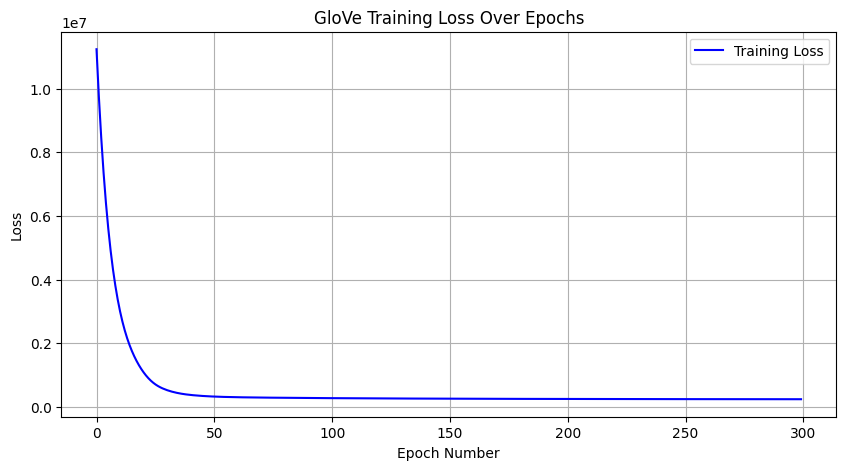

In [29]:
# @title c6.2 [0pt]
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss', color='blue')
plt.title('GloVe Training Loss Over Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


<font color="red">**Don't clear the output of the above cell!**</font>

### Validation (Similarity)

Curious to see what this network has learned? Let's perform a simple validation experiment.

We will check which words the model considers the most similar to other words. To that end, we need a notion of __similarity__. One of the most common measures of similarity in high-dimensional vector spaces is the cosine similarity.

The cosine similarity of two vectors $\vec{a}, \vec{b}$ is given as:
$$sim(\vec{a}, \vec{b}) = \frac{\vec{a}\cdot \vec{b}}{|\vec{a}|_2 \cdot |\vec{b}|_2}$$

where $|\vec{x}|_2$ is the $L_2$-norm of the $\vec{x}$.

The function `similarity` below accepts two words, a vocabulary and the network's output vectors, and computes the similarity between these two words. For an outside-vocabulary word similarity is 0.

In [30]:
def similarity(word_i: str, word_j: str, vocab: Dict[str, int], vectors: FloatTensor) -> float:
    if not(word_i in vocab and word_i in vocab): return 0.
    i, j = vocab[word_i], vocab[word_j]
    v_i = vectors[i] / torch.linalg.vector_norm(vectors[i])  # a/|a|
    v_j = vectors[j] / torch.linalg.vector_norm(vectors[j])  # b/|b|
    sim = torch.dot(v_i, v_j)
    return sim

Let's check out some examples. Consider the word pairs below and, optionally, add your own word pairs if it helps to support your answer:

In [31]:
word_vectors = network.get_vectors().detach()

for pair in [
    ("cruciatus", "imperius"),
    ("avada", "kedavra"),
    ("hogwarts", "school"),
    ("goblin", "hagrid"),
    ("giant", "hagrid"),
]:
    print(f"Similarity between '{pair[0]}' and '{pair[1]}' is: {similarity(pair[0], pair[1], vocab, word_vectors)}")

Similarity between 'cruciatus' and 'imperius' is: 0.4987607002258301
Similarity between 'avada' and 'kedavra' is: 0.6552069187164307
Similarity between 'hogwarts' and 'school' is: 0.7654938697814941
Similarity between 'goblin' and 'hagrid' is: 0.27460339665412903
Similarity between 'giant' and 'hagrid' is: 0.5027310848236084


#### i3 [2pt]
Give an interpretation of the results. Do the scores correspond well to your perceived similarity of these word pairs?

**ANSWER**:

**Interpretation of the results:**

**Cruciatus vs. Imperio:** These are two "Unforgivable Curses" from the Harry Potter universe. The similarity score (**0.498**) indicates a moderate relationship, reflecting that both words belong to the same category (dark magic) but are different types of curses.

**Avada vs. Kedavra:** These words represent the "Killing Curse" (Avada Kedavra). Their even higher similarity score (**0.655**) indicates a strong relationship, suggesting that the model recognizes them as closely related terms.

**Hogwarts vs. School:** This pair has a very high similarity (**0.765**), suggesting the model successfully learned that "Hogwarts" refers to a type of school.

**Goblin vs. Hagrid:** This similarity score (**0.275**) is lower than the previous ones. While goblins, that are magical creatures, and Hagrid, who is a half-giant, might have some interactions in the story, they are not closely related.

**Giant vs. Hagrid:** The score (**0.503**) is higher than the "Goblin vs. Hagrid" pair. Hagrid's physical description as a giant might contribute to this similarity.

To obtain the similarities of one word against all other words in the corpus, use torch functions and follow the equation ($\vec{c}_i$ is $i$th row of $\mathbf{C}$):
$$sim(\vec{w}, \mathbf{C}) = \frac{\vec{w}\cdot \mathbf{C}}{|\vec{w}|_2 \cdot |\mathbf{C}|_2} = \Big(\frac{\vec{w}\cdot \vec{c}_1}{|\vec{w}|_2 \cdot |\vec{c}_1|_2},\ldots,\frac{\vec{w}\cdot \vec{c}_N}{|\vec{w}|_2 \cdot |\vec{c}_N|_2}\Big)$$

Using `similarity` as a reference, write `similarities`, which accepts one word, a vocabulary and the network's output vectors and computes the similarity between the word and the entire corpus. **If a word is out of vocabulary, it should return a matrix of 0 similarities.**

_Hint_: $\mathbf{C} \in \mathbb{R}^{N, D}$, $\vec{w} \in \mathbb{R}^{1, D}$, $sim(\vec{w}, \mathbf{C}) \in \mathbb{R}^{1, N}$

In [32]:
# @title c7 [4pt]
def similarities(word_i: str, vocab: Dict[str, int], vectors: FloatTensor) -> FloatTensor:
    # use torch functions. Don't iterate over rows of vectors matrix!

    # Check if the word is in the vocabulary
    if word_i not in vocab:
        return torch.zeros(1, len(vocab), device=vectors.device)  # Return a tensor of zeros if the word is not in vocab

    # Get the index and the vector for the given word
    idx = vocab[word_i]
    word_vector = vectors[idx]

    # Normalize the word vector and the entire matrix
    normalized_word_vector = word_vector / torch.linalg.norm(word_vector)
    normalized_vectors = vectors / torch.linalg.norm(vectors, dim=1, keepdim=True)

    # Calculate the dot product between the word vector and each row of the matrix
    similarities = torch.matmul(normalized_word_vector.unsqueeze(0), normalized_vectors.t())

    return similarities

In [33]:
torch.tensor([1, 2, 3, 4]).unsqueeze(0)

tensor([[1, 2, 3, 4]])

In [34]:
# TEST c7a
assert similarities('harry', vocab, word_vectors).shape == torch.Size([1, len(vocab)])
assert similarities('cow', vocab, word_vectors).shape == torch.Size([1, len(vocab)])

Now we can manipulate the word vectors to find out what the corpus-wide most similar words to a query word are!

In [35]:
def most_similar(word_i: str, vocab: Dict[str, int], vectors: FloatTensor, k: int) -> List[str]:
    """ Returns a list of k words that are most similar to word_i
        The list excludes word_i itself
    """
    sims = similarities(word_i, vocab, vectors)
    _, topi = sims.topk(dim=-1, k=k+1)
    topi = topi.view(-1).cpu().numpy().tolist()
    inv = {v: i for i, v in vocab.items()}
    return [inv[i] for i in topi if inv[i] != word_i][:k]

In [36]:
# TEST c7b
for word in [
    "forbidden", "myrtle", "gryffindor", "wand", "quidditch", "marauder",
    "horcrux", "phoenix", "triwizard", "screaming", "letter"
]:
    print(f"Most similar words to '{word}': {most_similar(word, vocab, word_vectors, 6)}")

Most similar words to 'forbidden': ['shadows', 'grounds', 'forest', 'lawns', 'mountains', 'ahead']
Most similar words to 'myrtle': ['moaning', 'bathroom', 'hid', 'toilet', 'sobbing', 'properly']
Most similar words to 'gryffindor': ['ravenclaw', 'team', 'wood', 'possession', 'quidditch', 'beat']
Most similar words to 'wand': ['spoke', 'face', 'shot', 'onto', 'struggled', 'flew']
Most similar words to 'quidditch': ['winning', 'saturday', 'team', 'training', 'captain', 'seeker']
Most similar words to 'marauder': ['lucky', 'gotten', 'convinced', 'map', 'locked', 'set']
Most similar words to 'horcrux': ['sword', 'object', 'goblin', 'destroy', 'horcruxes', 'safe']
Most similar words to 'phoenix': ['feather', 'fawkes', 'spinning', 'building', 'connected', 'murder']
Most similar words to 'triwizard': ['tournament', 'champions', 'cedric', 'cup', 'champion', 'quidditch']
Most similar words to 'screaming': ['frozen', 'scream', 'voices', 'screams', 'cold', 'forced']
Most similar words to 'letter':

#### i4 [3pt]

Interpret the results in the context of Harry Potter books.
- Do these most similar words make sense (are they actually similar to the query words)?
- Are there any patterns you can see in the "errors" (the words that you wouldn't consider actually similar to the query word in general, in everyday life)?
- Which examples are instances of similarity (if any) and relatedness (if any)?
- Any other observations are welcome.

Illustrate your answers with examples from your model's output.

**ANSWER**:

Overall, the model has learned meaningful word relationships and similarities based on the context in which words appear in the corpus.

More specifically:

**"forbidden":** The most similar words include 'shadows', 'grounds', and 'forest', which makes sense in the context of "forbidden forest" (a key location in Harry Potter).

**"myrtle":** Closely associated with 'moaning', 'bathroom', and 'toilet', all of which relate to Moaning Myrtle, a ghost who haunts a bathroom at Hogwarts.

**"gryffindor":** Similar words include 'ravenclaw' (another house at Hogwarts), 'team', and 'quidditch', which are all related to the house's activities, especially its participation in Quidditch matches.

**"wand":** The most similar words are more abstract (e.g., 'spoke', 'face'), but this could be due to the way "wand" is used in a variety of contexts in the text.

**"quidditch":** Returns 'winning', 'team', 'captain', and 'seeker', which are key elements of the sport of Quidditch in the Harry Potter universe.

**"horcrux":** The results ('sword', 'object', 'goblin') make sense as Horcruxes are objects, and there are connections to the sword of Gryffindor, used to destroy Horcruxes.

**"phoenix":** Similar words include 'fawkes' (Dumbledore's phoenix) and 'feather', reinforcing the connection to the mythical bird.

**"triwizard":** The words 'tournament', 'champions', 'cedric', and 'cup' all relate to the Triwizard Tournament in the fourth book.

**"screaming":** Words like 'scream', 'voices', and 'screams' are directly related to the act of screaming, showing strong contextual relevance.

**"letter":** Similar words include 'letters', 'hedwig' (Harry's owl who delivers letters), and 'written', all closely related to communication through letters.

**Limitations and Errors:**

In some cases, the model returns overly general terms that don't provide specific context. For example, "wand" is associated with "spoke" and  "face" which might not be the most relevant words.

Furthermore, the model sometimes produces unexpected associations that may not be semantically accurate. For example, "phoenix" is associated with "murder," which is not a typical association for the mythical bird.

**Relatedness vs. Similarity:**

**Relatedness:** Some of the results reflect relatedness rather than strict similarity.

For instance, "horcrux" is associated with "sword" and "goblin," indicating a thematic connection rather than a direct synonym.

Also, "myrtle" is associated with "moaning" and "bathroom," reflecting her character's ghostly presence in the Hogwarts bathrooms.

Moreover, there is, association between "quidditch" and "winning" suggests an understanding of the competitive nature of the sport and "quidditch" is associated with "team," "training," and "captain," reflecting its status as a sport.

**Similarity:**

On the other hand, there are results that reflect similarity rather than relatedness.

For example, 'gryffindor' is assiciated with 'ravenclaw', since they are both Hogwarts houses.

Moreover, 'letter' is associated with 'letters' and 'screaming' is associated with 'screams' and 'voices', which are similar terms.

**Contextual Relationships:**

Additionally, there are **character-related associations**, since the model identifies words associated with specific characters. The word 'marauder' is linked to the word 'map,' reflecting its connection to the Marauder's Map.

Finally, there are **setting-related associations**, since the model captures associations with locations or settings. For example, 'forbidden' is associated with 'forest' and the Forbidden Forest is a place in the Harry Potter universe.

Overall it's quite impressive; we managed to encode a meaningful portion of the corpus statistics in only $30$ numbers per word!
(A compression ratio of >99%)

<div class="alert alert-block alert-info">
<b>Note:</b> The word vectors obtained by this process are (to a small extent) random, due to the random initialization of the embedding layers. If you are unhappy with your results, you can repeat the experiment a few times or try to toy around with the hyper-parameters (the smoothing factor of ${X}$, $x_{max}$, $\alpha$, the number of epochs and the dimensionality of the vector space). But do this as your own experiments outside the submission file.
</div>

Word vectors, however, contain way more information than just word co-occurrence statistics. Hold tight until the next assignment, where we will see how word vectors may be used to infer information spanning entire phrases and sentences.

### Validation (Word Analogies)

From the paper:
> The word analogy task consists of questions like "$a$ is to $b$ as $c$ is to __?" To correctly answer this question, we must find the word $d$ such that $w_d \approx w_b - w_a + w_c$ according to the cosine similarity.

Write your own function that performs the word analogy task.  
In addition to the standard approximation $w_d \approx w_b - w_a + w_c$, implement another non-standard but intuitive approximation where we are searching $w_d$ that maximizes teh following similarity $w_a - w_b \approx w_c - w_d$.  
Let's see which criteria will give the best results, or maybe both give the same results.    

_Hint_: Take a look at the code a few cells back. Most of what you need is already there.

In [37]:
# @title c8 [6pt]
def analogy(
    word_a: str, word_b: str, word_c: str, vocab: Dict[str, int],
    vectors: FloatTensor, k: int=5, standard: bool=True
) -> List[str]:
    """ Return a list of k words whose vectors are most similar to the solution vector of the analogy.
        The first element means the most similar, followed by the rest in decreasing similarity.
        word_a, word_b, and word_c are never returned as a part of the list.
        param standard=True uses the standard approximation equation, =False uses the alternative one.
    """
    # Check if all words are in the vocabulary
    if not (word_a in vocab and word_b in vocab and word_c in vocab):
        return []

    # Get the indices and vectors for word_a, word_b, and word_c
    idx_a, idx_b, idx_c = vocab[word_a], vocab[word_b], vocab[word_c]
    vec_a, vec_b, vec_c = vectors[idx_a], vectors[idx_b], vectors[idx_c]

    # Standard analogy: d ≈ b - a + c
    if standard:
        target_vec = vec_b - vec_a + vec_c

        # Normalize the target vector
        target_vec = target_vec / torch.linalg.norm(target_vec)

        # Normalize all word vectors
        normalized_vectors = vectors / torch.linalg.norm(vectors, dim=1, keepdim=True)

        # Compute similarities with all word vectors
        similarities = torch.matmul(normalized_vectors, target_vec)

    # Alternative analogy: maximize cos similarity between (a - b) and (c - d)
    else:
        diff_ab = vec_a - vec_b
        diff_cd = vec_c - vectors

        # Normalize diff_ab and diff_cd
        diff_ab = diff_ab / torch.linalg.norm(diff_ab)
        diff_cd = diff_cd / torch.linalg.norm(diff_cd, dim=1, keepdim=True)

        # Compute cosine similarities between (a - b) and (c - d) for all words d
        similarities = torch.matmul(diff_cd, diff_ab)

    # Get the top k most similar words, excluding word_a, word_b, and word_c
    _, topk = similarities.topk(k=k+3)  # topk +3 to account for excluding a, b, c
    topk = topk.cpu().numpy().tolist()

    # Get the inverse vocabulary (index -> word) and filter out a, b, c
    inv_vocab = {v: i for i, v in vocab.items()}
    result = [inv_vocab[i] for i in topk if inv_vocab[i] not in {word_a, word_b, word_c}]

    return result[:k]  # Return top k results


Some example triplets to test your analogies on:

In [38]:
# TEST c8
triplets = [("padma", "parvati", "fred"),
            ("avada", "kedavra", "expecto"),
            ("dungeon", "slytherin", "tower"),
            ("scabbers", "ron", "hedwig"),
            ("ron", "molly", "draco"),
            ("durmstrang", "viktor", "beauxbatons"),
            ("snape", "potions", "trelawney"),
            ("harry", "seeker", "ron"),
            # ---------------------
            ("ron", "hermione", "harry"),
            ("draco", "hermione", "harry"),
            ("snape", "lord", "dumbledore")
           ]

print("Mode: d ~ c - a + b")
for a, b, c in triplets:
    print("{:^16} is to {:^16} as {:^16} is to\t{}".format(a, b, c, analogy(a, b, c, vocab, word_vectors, 5, standard=True)))

print("\nMode: a - b ~ c - d")
for a, b, c in triplets:
    print("{:^16} is to {:^16} as {:^16} is to\t{}".format(a, b, c, analogy(a, b, c, vocab, word_vectors, 5, standard=False)))

Mode: d ~ c - a + b
     padma       is to     parvati      as       fred       is to	['pretending', 'george', 'mrs', 'told', 'ron']
     avada       is to     kedavra      as     expecto      is to	['patronum', 'slowed', 'dementor', 'hood', 'steam']
    dungeon      is to    slytherin     as      tower       is to	['gryffindor', 'training', 'points', 'hundred', 'ravenclaw']
    scabbers     is to       ron        as      hedwig      is to	['carrying', 'awake', 'parcel', 'time', 'five']
      ron        is to      molly       as      draco       is to	['coolly', 'narcissa', 'unaware', 'forgive', 'pleasantly']
   durmstrang    is to      viktor      as   beauxbatons    is to	['delacour', 'maxime', 'cedric', 'judges', 'support']
     snape       is to     potions      as    trelawney     is to	['herbology', 'divination', 'exams', 'exam', 'binns']
     harry       is to      seeker      as       ron        is to	['score', 'chasers', 'hufflepuff', 'flint', 'spectacular']
      ron        i

Some minimal emergent intelligence :) *(hopefully..)*. 🧙‍♀️

#### i5 [3pt]

Which analogy equation did give the best results for the provided analogy samples?  

Come up with three additional analogies in the context of Harry Potter.
Add them to the list of analogies in the code above and run the analogy computation.

Interpret the results of the best performing analogy equation (if any):
- For which analogies did the model manage to guess the correct answers (taking the first word in the output to be the model's "guess")?
- For which analogies are the correct answers present in the top K words?
- Do you see any patterns in the cases when the model didn't solve the task correctly? In other words, when the model's guess was wrong, can you suggest why the model guessed what it guessed?

**ANSWER**:

**Mode: d ≈ c - a + b**

| Word A | Word B | Word C | Model Guess | Correct Guess | Correct in Top-K |
|---|---|---|---|---|---|
| padma | parvati | fred | george | True | |
| avada | kedavra | expecto | patronum | True ||
| dungeon | slytherin | tower | gryffindor | True | |
| scabbers | ron | hedwig | carrying | False | harry (Not Present) |
| ron | molly | draco | narcissa | True | |
| durmstrang| viktor | beauxbatons | delacour | True | |
| snape | potions | trelawney | divination | True | |
| harry | seeker | ron | score | False | keeper (Not Present)  |
| ron | hermione | harry | nothing | False | ginny (Not Present) |
| draco | hermione  | harry | ron | False | bellatrix (Not Present)|
| snape | lord | dumbledore | sense | False | phoenix (Not Present) |

**Correct:** 6/11  
**Correct in Top-K:** 0/5

---

**Mode: a - b ≈ c - d**

| Word A | Word B | Word C | Model Guess | Correct Guess | Correct in Top-K |
|---|---|---|---|---|---|
| padma | parvati | fred | one | False | george (Not Present) |
| avada | kedavra | expecto | accident | False | patronum (Not Present) |
| dungeon | slytherin | tower | points | False | gryffindor (Present) |
| scabbers | ron | hedwig | cho | False | harry (Not Present) |
| ron | molly | draco | ere | False | narcissa (Not Present) |
| durmstrang | viktor | beauxbatons | delacour | True |  |
| snape | potions | trelawney | lunch | False | divination (Present) |
| harry | seeker | ron | score | False | keeper (Not Present) |
| ron | hermione | harry | heart | False | ginny (Not Present) |
| draco | hermione | harry | asleep | False | bellatrix (Not Present) |
| snape | lord | dumbledore | protection | False | phoenix (Not Present) |

**Correct:** 1/11

**Correct in Top-K:** 2/10

---

Comparing the results, the analogy equation that provided the best results is the first one (standard analogy). The model's incorrect guesses reveal several patterns.

One common issue is its **overreliance on word co-occurrence**. For instance, in **snape : lord :: dumbledore : protection**, it guessed "protection" because "Dumbledore" and "protection" frequently appear together.

Similarly, it tends to select **abstract words over specific roles or names**, as seen again in **padma : paravati :: fred : one**, where "one" was chosen instead of the specific answer "george".

The model also struggles with **specific roles** like in **harry : seeker :: ron : score**, where it guessed "score" instead of "keeper" (Ron's Quidditch position), perhaps because "score" is more broadly associated with the game.

Another pattern is its **bias toward common filler words**. For example, in **avada : kevadra :: expecto : accidents**, the model guessed "accidents," likely because it's a common word in the corpus, but missed the more personal relationship with "patronum."

Finally, the model has trouble with **personal relationships or named entities**, as seen again in **draco : hermione :: harry : heart**, where it guessed "heart" instead of recognizing the antagonism between Harry and Bellatrix.

These patterns show that while the model can handle general associations, it often fails with more nuanced or specific relationships, particularly when precision around roles, names, or familial connections is needed.

## Counting co-occurrences

In the beginning of the notebook you were provided with a pickle of co-occurrence counts. But how were these counts obtained? You will find this out when you complete this exercise.  

First, we obtain the plain text corpus of the Harry Potter book series and place the book files in the current directory.

In [39]:
!git clone https://github.com/ErikaJacobs/Harry-Potter-Text-Mining.git

Cloning into 'Harry-Potter-Text-Mining'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 106 (from 1)
Receiving objects: 100% (109/109), 13.39 MiB | 15.32 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [40]:
!cp Harry-Potter-Text-Mining/Book\ Text/* .

In research, it is relatively common that papers don't include all necessary details for replicating the experiments. This is often due to the lack of space in the paper, overlooking certain details, or simply a bad practice.

We will give you several hints on how the co-occurrence matrix was obtained. With the hints and the provided data in the pickle file, you should be able to replicate the exact content of the co-occurrence matrix from the pickle. Here are the hints:

1.   Tokenization of the data was done in a shallow but effective way: replace all punctuations with white space and delimit tokens with a sequence of white spaces;
2.   Standard libraries (!) were used for identifying punctuations and stopwords;
3.   Context windows are symmetric and don't span across chapters (i.e., the last word of chapter $N$ is not co-occuring with the first word of chapter $N+1$).
4.   The vocabulary was obtained based on the frequency cutoff.

To replicate the co-occurrence counts, complete the function below. Then use it to find out the exact values of `cutoff` and `window_size` that result in the co-occurrence counts identical to the provided ones. No need to provide the code for finding the exact values. Just use them in the next TEST code cell.

Feel free to import any standard python library. Use the same cell code for importing libraries and defining auxiliary functions (if any).
The code will be evaluated not only on the correctness of the output but also on efficiency. It should be able to extract the counts and create the tensor in less than a minute (in the colab environment).

In [41]:
# @title c9 [12pt]

import re
from collections import defaultdict
from typing import List, Tuple
import nltk
from nltk.corpus import stopwords
import string

# Download NLTK stopwords
nltk.download('stopwords')

def read_book_files(files: List[str], cutoff: int = 10, window_size: int = 20,
                    verbose: bool = False) -> Tuple[dict, dict, torch.Tensor]:
    """ Input:
            file - a list of file paths;
            cutoff - vocab excludes words with occurrence counts < cutoff;
            window_size - size of the left and right windows (individually);
            verbose - when set to False prints nothing
        Outputs a tuple of:
            voc - mapping of vocabulary to indices;
            dd_cnt - dict of dict of co-occurrence counts;
            X - Tensor with |vocab|x|vocab| size and co-occurrence counts
    """
    # Step 1: Read and preprocess text files
    text_data = []
    for file in files:
        with open(file, 'r', encoding='utf-8') as f:
            for line in f:
                # Split by the delimiter @ and take the first part (text)
                parts = line.split('@')
                if len(parts) > 0:
                    text_data.append(parts[0].strip('\"'))  # Take only the text part

    # Step 2: Combine the text data
    text = "\n".join(text_data)

    # Step 3: Remove punctuation
    tokens = re.sub(f"[{re.escape(string.punctuation)}]", " ", text).lower().split()

    # Step 4: Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Step 5: Create frequency dictionary
    freq = defaultdict(int)
    for token in tokens:
        freq[token] += 1

    # Step 6: Apply frequency cutoff and create vocabulary
    # Create a list of words that meet the frequency cutoff
    vocab_items = [(word, count) for word, count in freq.items() if count >= cutoff]

    # Sort the vocabulary items alphabetically
    vocab_items.sort(key=lambda x: x[0])  # Sort by word (key)

    # Create the vocabulary with token as key and index as value
    voc = {word: idx for idx, (word, count) in enumerate(vocab_items)}

    # Initialize co-occurrence counts
    dd_cnt = defaultdict(lambda: defaultdict(int))

    # Step 7: Count co-occurrences with context windows
    # For each chapter
    for chapter in text_data:
        # Remove punctuation to get the valid words
        valid_words = re.sub(f"[{re.escape(string.punctuation)}]", " ", chapter).lower().split()

        for i, word in enumerate(valid_words):
            # Determine context window
            left_context = valid_words[max(0, i - window_size):i]
            right_context = valid_words[i + 1:min(len(valid_words), i + 1 + window_size)]

            # Count co-occurrences
            context_words = left_context + right_context
            for context_word in context_words:
                if word in voc and context_word in voc:
                    dd_cnt[word][context_word] += 1

    # Step 8: Create the co-occurrence matrix (Tensor)
    X = torch.zeros(len(voc), len(voc))

    for word, contexts in dd_cnt.items():
        for context_word, count in contexts.items():
            # if word in voc and context_word in voc:
            X[voc[word], voc[context_word]] = count

    return voc, dd_cnt, X

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [42]:
# TEST
# YOUR CODE HERE - Fill in the found cutoff and window_size values
# it shouldn't take more than 2min
%%time
my_vocab, my_contexts, my_X = read_book_files([ f"HPBook{n}.txt" for n in range(1,8) ], cutoff=16, window_size=25)

CPU times: user 40.6 s, sys: 330 ms, total: 40.9 s
Wall time: 41.2 s


In [43]:
# TEST c9
# This makes sure the value types are as expected
assert my_vocab['1'] == 0
assert isinstance(my_vocab, dict)
assert isinstance(my_contexts, dict)
assert 'potter' in my_contexts['harry']
assert isinstance(my_X, torch.Tensor)
assert my_X.size() == (4298,4298)

<font color="red">**Don't clear the output of the above cell!**</font>

#### i6 [3pt]

What are the values of `cutoff` and `window_size` that replicates the provided counts?

Briefly describe the process of finding the correct underlying algorithm of `read_book_files` and the correct values of `cutoff` and `window_size`.  
Be concise. 100-150 words can be more than enough for the description.

**ANSWER**:

**Cutoff:** This parameter determines the minimum number of occurrences a word must have to be included in the vocabulary. Increasing the cutoff will result in a smaller vocabulary, while decreasing it will increase the vocabulary size.

**Window Size:** This parameter determines the number of words to consider on either side of a target word for co-occurrence counts. A larger window size means more context, which can lead to higher co-occurrence counts.

---

The text preprocessing step was done based on the details of the assignment. We replaced all punctuations with white space and delimited tokens with a sequence of white spaces, using standard libraries to identify punctuations and stopwords.

After that, we run the function for different frequency cutoff values until we found the ideal cutoff value, where our vocabulary had the same size and the same tokens as the original vocabulary.

To find out the context window size, we first made sure that wontext windows in our code are symmetric and don't span across chapters, as mentioned in the assignment.

Then, we considered the most infrequent co-occurences. More specifically, by looking at the original co-occurrence matrix, we looked for them singularly and we considered the distance between the words.

For example, a value equal to 1 in the co-occurrence matrix means that a context word co-occurs only once with another word and the distance between this word and its context word in the text indicates the minimum window size.

This way we realized that stopwords have to be included in the context window.

After that, we run the function for different window sizes until we found the ideal window size value, where the co-occurences in our co-occurrence matrix were the same as the original co-occurrence matrix.


### Optional
If you are done, you can continue experimenting in order to understand the system's behaviour better. For example: how does training and hyperparameter choice affect the model's performance?
Repeat the training using your own hyperparameters (vector space dimensionality, optimizer parameters, the number of training epochs, a different random seed, etc.).

During the training loop, print the qualitative benchmarks every few epochs. Do they keep improving? Is there any disadvantage to exhaustively training until convergence?

Now you have all the tools at hand to train the word vectors on any textual corpus.

# Acknowledgment

The jupyter notebook was initially created by Konstantinos Kogkalidis and Tejaswini Deoskar.  
Recent changes, including adaptation to the Colab environment and the exercise on reconstructing a co-occurrence matrix, are by Lasha Abzianidze.